In [1]:
%load_ext watermark
%watermark

2019-01-16T21:32:16-06:00

CPython 3.7.1
IPython 7.2.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [12, 12]
np.random.seed(42)

# Descomposición en Valores Singulares (SVD)

En esta sección vamos a ver aplicaciones prácticas de SVD así como su implementación en scipy y en scikit-learn

Recordamos que el método SVD descompone una matriz en sus factores singulares: 

$$\underset{(n \times d)}{A} = \underset{(n \times n)}{U} \underset{(n \times d)}{\Sigma}\underset{(d \times d)}{V^T}$$

### Ejemplo. Compresión de datos.

SVD puede ser utilizado para comprimir imágenes, extrayendo aquellos componentes que son fundamentales a la hora de representar lo que hay en las imágenes y eliminando el resto (el ruido).

Para este ejemplo vamos a usar el dataset [Labeled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/) que contiene un conjunto de imágenes de personajes famosos enfocado al reconocimiento facial (y que es un dataset desarrollado por la universidad donde hice mi proyecto final de carrera, **let's go UMASS!**)

In [3]:
from sklearn.datasets import fetch_lfw_people

In [4]:
caras = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

caras.images = caras.images[:10]
caras.target = caras.target[:10]

In [20]:
caras.target_names[caras.target]

array(['Winona Ryder', 'Jean Chretien', 'Carlos Menem', 'Ariel Sharon',
       'Alvaro Uribe', 'Colin Powell', 'Recep Tayyip Erdogan',
       'Gray Davis', 'George Robertson', 'Silvio Berlusconi'],
      dtype='<U25')

In [7]:
caras.target

array([61, 25,  9,  5,  1, 10, 48, 17, 13, 54])

In [8]:
caras.images.shape

(10, 87, 65)

El dataset consiste de 3020 imágenes de famosos (los famosos aparecen múltiples veces). La variable objetivo es el nombre del famoso.

Las imágenes son básicamente arrays de numeros donde cuanto mayor sea el número más claro es el píxel (son imágenes de tamaño 87 pixeles de anchura por 65 de altura).

In [9]:
caras.images[0]

array([[ 57.      ,  60.333332,  78.      , ...,  40.666668,  36.666668,
         34.      ],
       [ 52.666668,  60.      ,  92.      , ...,  46.666668,  36.      ,
         30.      ],
       [ 46.      ,  66.      , 113.333336, ...,  51.      ,  43.333332,
         37.666668],
       ...,
       [ 61.      ,  62.666668,  62.333332, ...,  19.      ,  18.333334,
         18.666666],
       [ 62.666668,  64.666664,  67.      , ...,  17.333334,  18.      ,
         22.333334],
       [ 65.333336,  68.      ,  67.      , ...,  17.333334,  16.666666,
         22.666666]], dtype=float32)

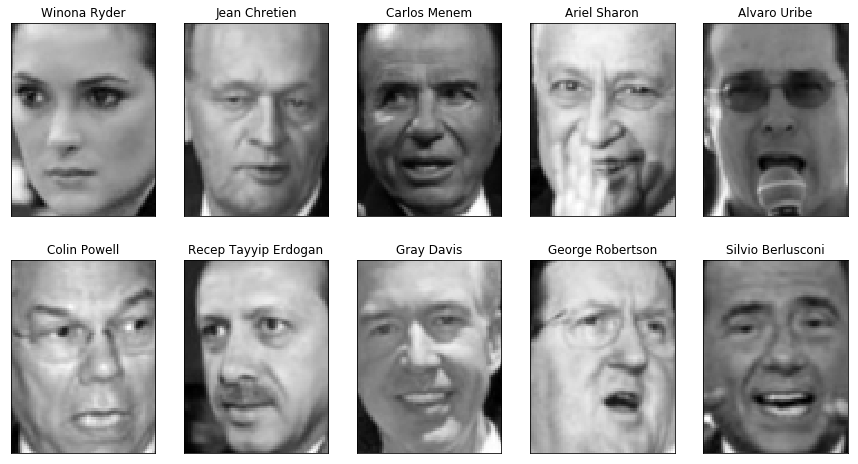

In [12]:
image_shape = caras.images[0].shape

def dibujar_caras(arrays_caras):
    fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
    for target, image, ax in zip(caras.target, arrays_caras, axes.ravel()):
        ax.imshow(image, cmap="gray")
        ax.set_title(caras.target_names[target])
        
dibujar_caras(caras.images);

Creamos una función auxiliar para mostrar imágenes.

In [14]:
def dibujar_cara(matriz_cara):
    plt.figure(figsize=(9,6))
    plt.imshow(matriz_cara, cmap='gray');

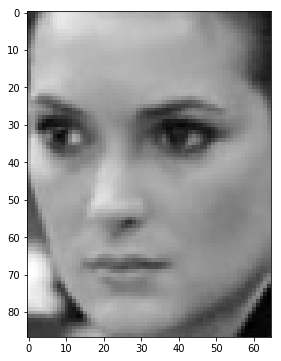

In [19]:
dibujar_cara(caras.images[0])

Podemos usar `nbytes` en un array de numpy para ver el tamaño en memoria del mismo

In [20]:
def kb_totales(*arrays):
    return sum(map(lambda a: a.nbytes, arrays)) / 1024

Ahora podemos usar esta función para calcular el tamaño en memoria de cualquier número de arrays de numpy

In [21]:
kb_totales(caras.images[0])

22.08984375

Vemos que cada imagen tiene un tamaño de 22 kilobytes aproximadamente

Para hacer una descomposición SVD completa podemos usar el método [`scipy.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd).

In [22]:
from scipy.linalg import svd

In [23]:
svd?

In [24]:
U, s, V = np.linalg.svd(caras.images[0], full_matrices=True)

In [26]:
 U.shape, s.shape, V.shape

((87, 87), (65,), (65, 65))

Vemos que el método svd no devuelve la matriz de valores singulares Sigma como matriz, sino como vector (el resto de elementos son 0). La convertimos a una matriz diagonal de tamaño $87\times65$.

In [27]:
S = np.zeros((U.shape[0], V.shape[0]))
S[:V.shape[0], :V.shape[0]] = np.diag(s)
S.shape

(87, 65)

In [28]:
S

array([[10847.68457031,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  1495.50854492,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,   967.43719482, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

Podemos recomponer la imagen original haciendo el producto de las matrices U, S y V.

In [29]:
cara_svd = U @ S @ V

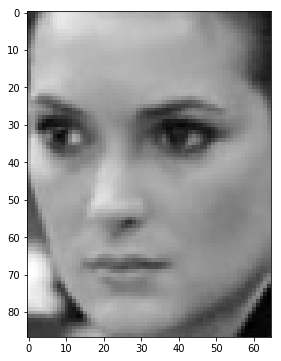

In [30]:
dibujar_cara(caras.images[0])

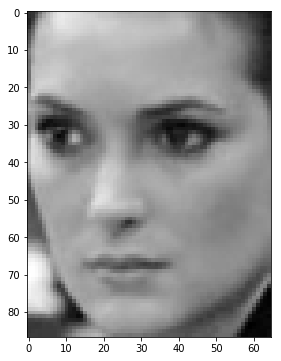

In [31]:
dibujar_cara(cara_svd)

In [32]:
kb_totales(U, s, V)

46.32421875

Vemos que las matrices factores de la imagen ocupan más tamaño que la imagen original (47 kb versus 22 kb). Sin embargo, hemos realizado una descomposición total (**Full SVD**).

Se puede descomponer usando un número específico de valroes singulares **K** que sea menor que d y utilizarlos para recomponer la imagen a costa de perder algo de información.

In [34]:
from ipywidgets import IntSlider, interact

@interact(k=IntSlider(65, min=1, max=65))
def evaluar_k_imagen(k):
    U_k = U[:, :k]
    s_k = s[:k]
    V_k = V[:k, :]
    memoria_k = kb_totales(U_k, s_k, V_k)
    # Calculamos la reduccion en tamaño respecto a la imagen original
    pct_reduccion = 100 * (1 - (memoria_k / kb_totales(caras.images[0])))
    imagen_k_svd =  U_k @ np.diag(s_k) @ V_k
    dibujar_cara(imagen_k_svd)
    plt.title("{} valores singulares, tamaño: {:.1f} kb ({:.1f}% menor)".format(
    k, memoria_k, pct_reduccion), size=20)
    plt.show();

interactive(children=(IntSlider(value=65, description='k', max=65, min=1), Output()), _dom_classes=('widget-in…

Vemos que podemos seguir reduciendo K y obteniendo una imagen bastante fiel con una reducción de tamaño considerable.

# Ejemplo. Sistemas de Recomendación.

Como hemos visto el Método descompone una matriz en un producto de sus factores, descomponiendola en sus vectores y valores singulares. El resultado no és exactamente igual que la matriz original, ya que al extraer los valores singulares, se ha eliminado aquella información que no es fundamental al dataset.

Por ello, una aplicación interesante de SVD es en los Sistemas de recomendación. Dado que al aplicar SVD a una matriz la estamos de alguna forma limpiando, podemos conseguir mostrar información latente de la misma. 

Por ejemplo, si tenemos datos de películas que han visto usuarios y si les han gustado o no, en general para cada usuario, habrá un gran porcentaje de películas que no han evaluado, y por lo tanto no sabemos si le gustan o no. Si pensamos en dicho dataset como una matriz de N usuarios y d películas, podemos usar SVD para rellenar los huecos de dicha matriz y predecir la puntuación que un usuario le daria a una película que aún no ha visto.

Para este ejemplo vamos a usar una versión reducida del dataset [Movielens](https://grouplens.org/datasets/movielens/), que contiene datos de la página **movielens.org**, una página donde se pueden evaluar y comentar películas.

Cargamos los datos

In [35]:
ratings = pd.read_csv("data/ratings.csv")
ratings.shape

(183142, 3)

In [36]:
ratings.head()

,usuario,pelicula,rating
0,1,1193,5
1,1,2355,5
2,1,1197,3
3,1,2804,5
4,1,919,4


Vemos que este dataset tiene una lista de puntuaciones (en una escala del 1 al 5) que cada usuario ha dado a una película.

Vamos a convertirlo en una matriz de N usuarios por d películas

In [38]:
ratings_mtx_df = ratings.pivot_table(values='rating', index='usuario',
                                     columns='pelicula')
movie_index = ratings_mtx_df.columns

In [39]:
ratings_mtx_df.shape

(6035, 100)

In [40]:
ratings_mtx_df.head()

pelicula,1,21,32,34,39,50,110,223,260,296,...,2959,2987,2997,3114,3175,3418,3471,3481,3578,3793
usuario,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,5.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,4.0,3.0,5.0,NaN,NaN,NaN,4.0,...,4.0,4.0,5.0,NaN,NaN,3.0,NaN,NaN,2.0,2.0


Tenemos 924 usuarios y 3416 películas. Como vemos en el dataset la mayor parte del mismo está vacía (ya que hay muchas más películas que los usuarios no han evaluado que peliculas que han evaluado)

convertimos el dataframe a una matriz de numpy, imputando los ratings no existentes

In [42]:
ratings_mtx = ratings_mtx_df.fillna(0).as_matrix().copy()

/home/erdvillegas/anaconda3/envs/Datascientist/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [46]:
ratings_mtx

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 4., ..., 0., 0., 0.]])

In [49]:
from scipy import sparse
ratings_mtx_sparce = sparse.csr_matrix(ratings_mtx)

In [51]:
ratings_mtx_sparce

<6035x100 sparse matrix of type '<class 'numpy.float64'>'
	with 183142 stored elements in Compressed Sparse Row format>

Para calcular la descomposición svd, vamos a usar ahora la función de scipy [`svds`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) que calcula SVD truncado con k valores singulares.

In [52]:
from scipy.sparse.linalg import svds

In [53]:
U,s, V = svds(ratings_mtx,  k=10)

In [54]:
U.shape, s.shape, V.shape

((6035, 10), (10,), (10, 100))

Vemos que con `svds`, las matrices **U** y **V** no son cuadradas, sino que son una submatriz conteniendo los *k* primeros vectores singulares izquierdos y derechos. Tambien nos devuelve sigma como vector de valores singulares lo tenemos que convertir a una matriz diagonal

In [56]:
s_diag_matrix = np.zeros((s.shape[0], s.shape[0]))

for i in range(s.shape[0]):
    s_diag_matrix[i,i] = s[i]

Si hacemos el producto de u, s y vt obtenemos una matriz de la forma original de la matriz de ratings

In [57]:
ratings_svd = U @ s_diag_matrix @ V

In [59]:
ratings_svd.shape

(6035, 100)

In [61]:
ratings_svd

array([[ 2.69741551, -0.42107844, -0.10678392, ..., -0.26837044,
        -0.07062393, -0.03607874],
       [ 0.4586078 ,  1.13121114,  0.60552692, ...,  0.98104388,
         2.44617721,  0.97296977],
       [ 2.11194629,  0.51996779, -0.5966718 , ...,  1.21861787,
         0.69743444,  0.85914404],
       ...,
       [ 0.33656183, -0.04525818, -0.18362975, ..., -0.01014997,
         0.21265078,  0.12903017],
       [ 2.05057021,  0.08789171,  0.2990587 , ...,  0.42525262,
        -0.44681095,  0.11289977],
       [ 2.26959795,  0.96632394,  2.79499327, ...,  1.51207585,
         0.57448459,  0.57109069]])

Vemos que pese a que se ha perdido la escala de los datos (no están en una escala de 1 a 5, se ha "rellenado" la matriz

### Ejemplo. Reducción de dimensionalidad con SVD Truncada en scikit-learn.


In [62]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [63]:
cancer.data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [64]:
cancer.data.shape

(569, 30)

In [65]:
from sklearn.decomposition import TruncatedSVD
print(TruncatedSVD.__doc__)

Dimensionality reduction using truncated SVD (aka LSA).

    This transformer performs linear dimensionality reduction by means of
    truncated singular value decomposition (SVD). Contrary to PCA, this
    estimator does not center the data before computing the singular value
    decomposition. This means it can work with scipy.sparse matrices
    efficiently.

    In particular, truncated SVD works on term count/tf-idf matrices as
    returned by the vectorizers in sklearn.feature_extraction.text. In that
    context, it is known as latent semantic analysis (LSA).

    This estimator supports two algorithms: a fast randomized SVD solver, and
    a "naive" algorithm that uses ARPACK as an eigensolver on (X * X.T) or
    (X.T * X), whichever is more efficient.

    Read more in the :ref:`User Guide <LSA>`.

    Parameters
    ----------
    n_components : int, default = 2
        Desired dimensionality of output data.
        Must be strictly less than the number of features.
        T

In [67]:
svd = TruncatedSVD(n_components=2)
svd.fit(cancer.data)

cancer_svd = svd.transform(cancer.data)

Una vez hemos ajustado el transformador el atributo `components` contiene los vectores singulares del dataset original, y el atributo `singular_values_` para ver los valores singulares.


In [68]:
svd.components_

array([[ 1.07417853e-02,  1.34045777e-02,  7.04506088e-02,
         5.72522445e-01,  6.51751678e-05,  8.01017182e-05,
         8.07639302e-05,  4.51934799e-05,  1.22298430e-04,
         4.10463505e-05,  3.52395083e-04,  7.91756415e-04,
         2.49763979e-03,  4.15710660e-02,  4.46726431e-06,
         1.84034785e-05,  2.35606720e-05,  8.71328141e-06,
         1.33301479e-05,  2.50009455e-06,  1.27106222e-02,
         1.78787301e-02,  8.44072509e-02,  8.10936848e-01,
         8.96729192e-05,  1.95800247e-04,  2.25664038e-04,
         9.56995686e-05,  1.97533332e-04,  5.62166955e-05],
       [-3.10857421e-02, -4.83124253e-02, -1.97364828e-01,
        -7.70224130e-01, -2.62097172e-04, -1.75341873e-04,
        -4.07661495e-05, -1.69018436e-05, -4.97684199e-04,
        -1.84499403e-04, -8.41315666e-05, -4.03047670e-03,
        -1.33910533e-03,  6.79661807e-02, -2.42657052e-05,
        -6.56841723e-05, -8.35322707e-05, -3.01365028e-05,
        -7.25209655e-05, -1.16619632e-05, -2.41432752e-

In [69]:
svd.components_.shape

(2, 30)

In [70]:
svd.singular_values_

array([30786.44462784,  2480.44578339])

Una vez hemos ajustado el transformador podemos usar el atributo `explained_variance_ratio` para ver que porcentaje de la varianza inicial de los datos se puede explicar por cada vector singular.


In [71]:
svd.explained_variance_ratio_

array([0.97440781, 0.02168862])

In [72]:
cancer_svd

array([[2241.97427647,  347.71556015],
       [2372.40840267,   56.90166991],
       [2101.8402797 ,   11.94762737],
       ...,
       [1424.53280954,  -55.0217124 ],
       [2231.65579282,   19.99439854],
       [ 331.69302638,   -5.29733966]])

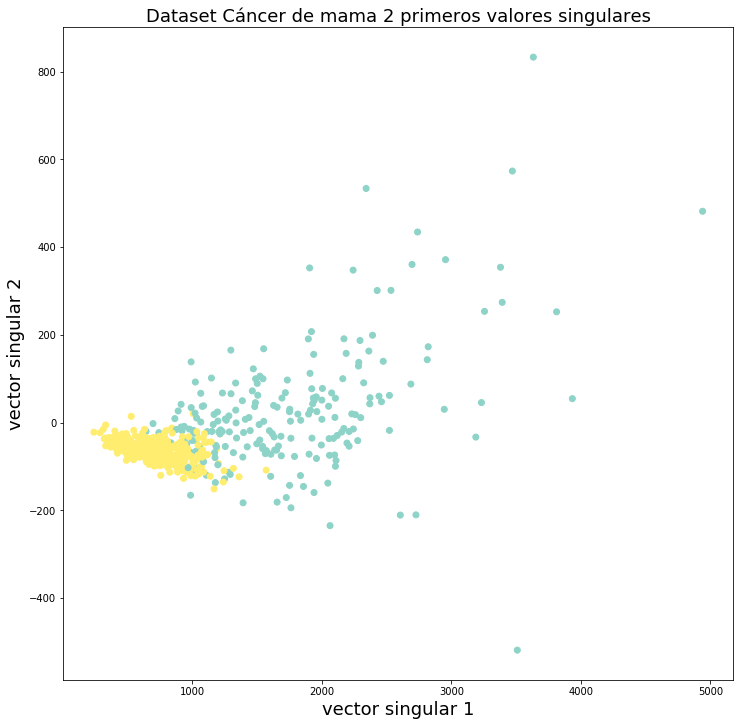

In [73]:
from matplotlib import cm

fig = plt.figure(figsize=(12,12))
plt.scatter(cancer_svd[:, 0], cancer_svd[:, 1], c=cancer.target, cmap=cm.Set3)
plt.title("Dataset Cáncer de mama 2 primeros valores singulares", size=18)
plt.xlabel("vector singular 1", size=18)
plt.ylabel("vector singular 2", size=18);

Vemos como al reducir el dataset a 2 dimensiones se aprecia una separación de la s clases